# Load Data

In [601]:
import numpy as np
import json
import csv

k = 3
X = np.loadtxt('../data/softkmeans_logloss_X%d.csv' % k, delimiter=',')
Y = np.loadtxt('../data/softkmeans_logloss_Y%d.csv' % k, delimiter=',')

data = np.genfromtxt('../data/all_samples_both_instruments_filtered.csv', delimiter=',', skip_header=True)
data = data[:, 1:]
print(data)
m, n = data.shape

with open('../data/all_samples_both_instruments_filtered_labels.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    key_to_index = dict([(h, i) for i, h in enumerate(header[1:])])
    data_labels = [x[1:] for x in reader]
    

with open('../data/all_samples_both_instruments_filtered.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    
def get_label(i, key):
    return data_labels[i][key_to_index[key]]
        
print(get_label(0, 'ADIR:diagnosis'))
print(X.shape, Y.shape)

[[ nan   0.   2. ...,   0.   1.   1.]
 [ nan   0.   2. ...,   1.   1.   1.]
 [ nan  nan  nan ...,   1.   0.   0.]
 ..., 
 [  0.  nan   0. ...,   0.   0.   0.]
 [  0.  nan   0. ...,   0.   0.   0.]
 [  0.  nan   0. ...,   1.   0.   0.]]
Autism
(3, 9100) (3, 185)


In [651]:
# Pull age and gender
with open('../data/all_samples_both_instruments.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    gender, age = [], []
    for line in reader:
        gender.append(line[7])
        if line[15] != 'None':
            age.append(int(line[15]))
        elif line[328] != 'None':
            age.append(int(line[328]))
        else:
            age.append(None)
print(age[:10])

[161, 117, 88, 62, 113, 53, 42, 74, 42, 69]


# Understand our validation data
Our validation data comes from ADIR and ADOS. Both give a diagnosis, and both also break down that diagnosis into three categories: communication, social interaction, and restricted and repeptitive behavior. These are the diagnostic criteria for ASD. Let's take a look at how these scores are distributed across our dataset.

## Diagnosis
This pie chart shows the diagnosis distribution across our dataset. The first diagnosis is ADIR and the second is ADOS. They have only 81% concordance.

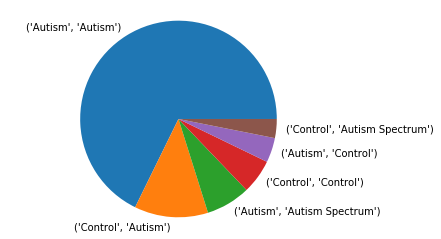

0.807032967032967


In [544]:
c = Counter([(get_label(i, 'ADIR:diagnosis'), get_label(i, 'ADOS:diagnosis')) for i in range(m)])
keys = [k for k, v in c.most_common()]
plt.pie([c[k] for k in keys], labels=keys)
plt.axis('equal')
plt.show()

print(sum([v for k, v in c.items() if (('Autism' in k[0] and 'Autism' in k[1]) or ('Control' in k[0] and 'Control' in k[1]))])/sum([v for v in c.values()]))


## Subscores - Communication, Social Interaction, and Restricted Repetitive Behavior
The communication scores are not correlated.

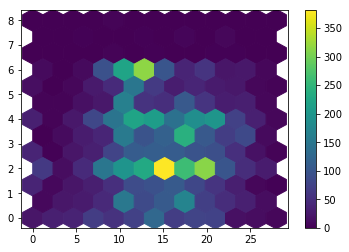

(-0.023213093331833932, 0.028415229048177858)


In [258]:
adir_com = [int(get_label(i, 'ADIR:communication')) for i in range(m)]
ados_com = [int(get_label(i, 'ADOS:communication')) for i in range(m)]

# remove double zeros
com = zip(adir_com, ados_com)
com = [(a, b) for a, b in com if a>0 or b>0]

# plot
cay = plt.hexbin([a for a, b in com], [b for a, b in com], gridsize=12)
plt.colorbar(cay)
plt.show()

# pearson r
from scipy.stats.stats import pearsonr
print(pearsonr(np.asarray([a for a, b in com], float), np.asarray([b for a, b in com], float)))

The social interaction scores are correlated - pearson r is 0.43

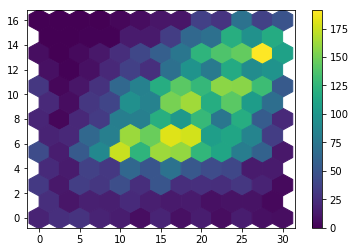

(0.43076994497652366, 0.0)


In [259]:
adir_si = [int(get_label(i, 'ADIR:social_interaction')) for i in range(m)]
ados_si = [int(get_label(i, 'ADOS:social_interaction')) for i in range(m)]

# remove double zeros
si = zip(adir_si, ados_si)
si = [(a, b) for a, b in si if a>0 or b>0]

# plot
cay = plt.hexbin([a for a, b in si], [b for a, b in si], gridsize=12)
plt.colorbar(cay)
plt.show()

# pearson r
print(pearsonr(np.asarray([a for a, b in si], float), np.asarray([b for a, b in si], float)))

The restricted, repetitive behavior scores are weakly correlated - pearson r is .11

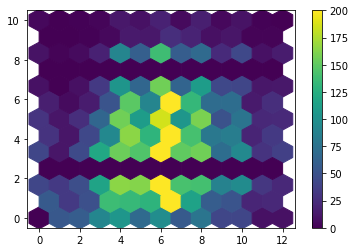

(0.11481944981684143, 2.3579564259200109e-27)


In [262]:
adir_rrb = [int(get_label(i, 'ADIR:restricted_repetitive_behavior')) for i in range(m)]
ados_rrb = [int(get_label(i, 'ADOS:restricted_repetitive_behavior')) for i in range(m)]

# remove double zeros
rrb = zip(adir_rrb, ados_rrb)
rrb = [(a, b) for a, b in rrb if a>0 or b>0]

# plot
cay = plt.hexbin([a for a, b in rrb], [b for a, b in rrb], gridsize=12, vmax=200)
plt.colorbar(cay)
plt.show()

# pearson r
print(pearsonr(np.asarray([a for a, b in rrb], float), np.asarray([b for a, b in rrb], float)))

In [545]:
print(np.sum(X, 1))

[ 3202.4651867   2244.54939294  3652.98542036]


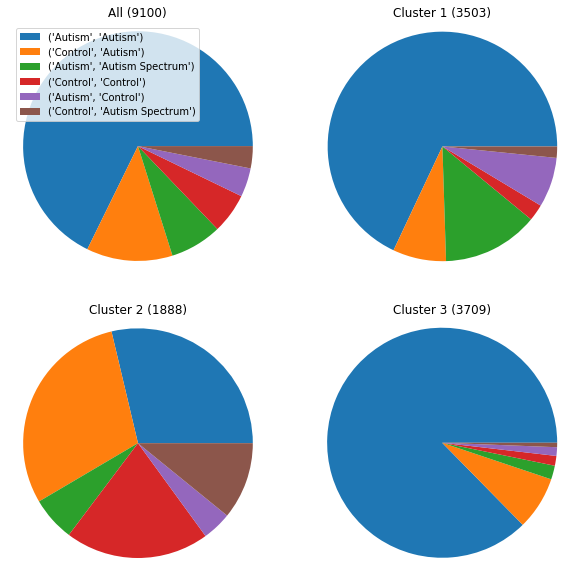

In [615]:
from collections import Counter
import math

all_c = Counter([(get_label(i, 'ADIR:diagnosis'), get_label(i, 'ADOS:diagnosis')) for i in range(m)])
keys = [k for k, v in all_c.most_common()]

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
c = Counter([(get_label(index, 'ADIR:diagnosis'), get_label(index, 'ADOS:diagnosis')) for index in range(m)])
plt.pie([c[k] for k in keys])
plt.title('All (%d)' % m)
plt.axis('equal')
plt.legend(loc="upper left", labels=keys)
    
for i in range(k):
    #indexes = np.where(X[i, :]==1)[0]
    indexes = np.where(X[i, :]==np.amax(X, axis=0))[0]
    #indexes = np.where(X[i, :]> 0)[0]
    c = Counter([(get_label(index, 'ADIR:diagnosis'), get_label(index, 'ADOS:diagnosis')) for index in indexes])
    
    plt.subplot(2, 2, i+2)
    plt.pie([c[k] for k in keys])
    plt.title('Cluster %d (%d)' % (i+1, len(indexes)))
    plt.axis('equal')
    

plt.show()
    

            

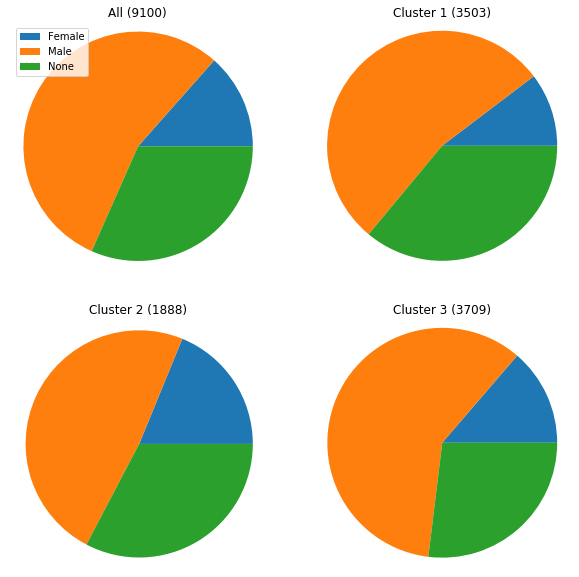

In [627]:
from collections import Counter
import math

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
c = Counter(gender)
keys = c.keys()
plt.pie([c[k] for k in keys])
plt.title('All (%d)' % m)
plt.axis('equal')
plt.legend(loc="upper left", labels=keys)
    
for i in range(k):
    #indexes = np.where(X[i, :]==1)[0]
    indexes = np.where(X[i, :]==np.amax(X, axis=0))[0]
    #indexes = np.where(X[i, :]> 0)[0]
    c = Counter([gender[index] for index in indexes])
    
    plt.subplot(2, 2, i+2)
    plt.pie([c[k] for k in keys])
    plt.title('Cluster %d (%d)' % (i+1, len(indexes)))
    plt.axis('equal')
    

plt.show()
    

            

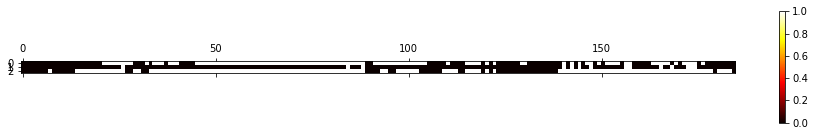

In [555]:
import matplotlib.pyplot as plt
cay = plt.matshow(Y>0, cmap='hot')
plt.colorbar(cay)
plt.show()

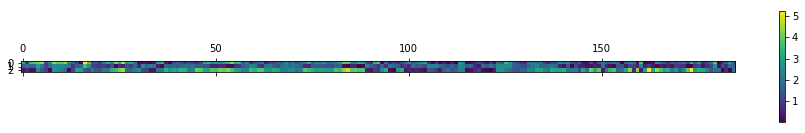

In [556]:
cay = plt.matshow(abs(Y))
plt.colorbar(cay)
plt.show()

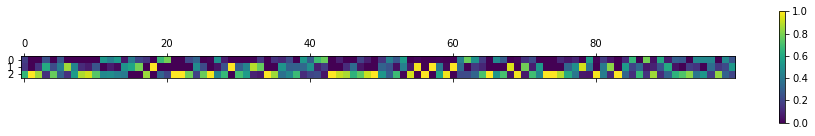

In [557]:
cay = plt.matshow(X[:, :100])
plt.colorbar(cay)
plt.show()

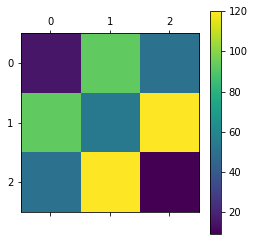

In [558]:
def missing_value_distance(a, b, n):
    dist = 0
    for i in range(n):
        if ~np.isnan(a[i]) and ~np.isnan(b[i]):
            if (a[i] < 0 and b[i] > 0) or (a[i] > 0 and b[i] < 0):
                dist += 1
            
    return dist

D = np.zeros((k, k))
for i in range(k):
    for j in range(k):
        if i < j:
            dist = missing_value_distance(Y[i, :], Y[j, :], n)
            D[i, j] = dist
            D[j, i] = dist
        elif i == j:
            indexes = np.where(X[i, :]> .4)[0]
            for x in indexes:
                D[i, i] += missing_value_distance(data[x, :], Y[i, :], n)
            D[i, i] = D[i, i]/len(indexes)
    
cay = plt.matshow(D)
plt.colorbar(cay)
plt.show()

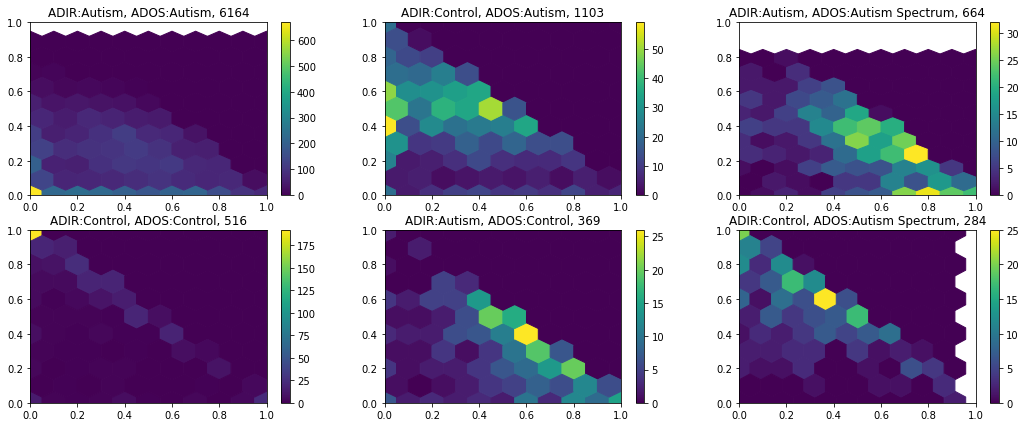

In [570]:
key_indexes = np.asarray([keys.index((get_label(i, 'ADIR:diagnosis'), get_label(i, 'ADOS:diagnosis'))) for i in range(m)])

plt.figure(figsize=(18, 7))
for i, key in enumerate(keys):
    plt.subplot(2, 3, i+1)
    plt.axis((0,1,0,1))
    cay = plt.hexbin(X[0, key_indexes==i], X[1, key_indexes==i], gridsize=10)
    plt.colorbar(cay)
    plt.title('ADIR:%s, ADOS:%s, %d' % (key[0], key[1], all_c[key]))
plt.show()

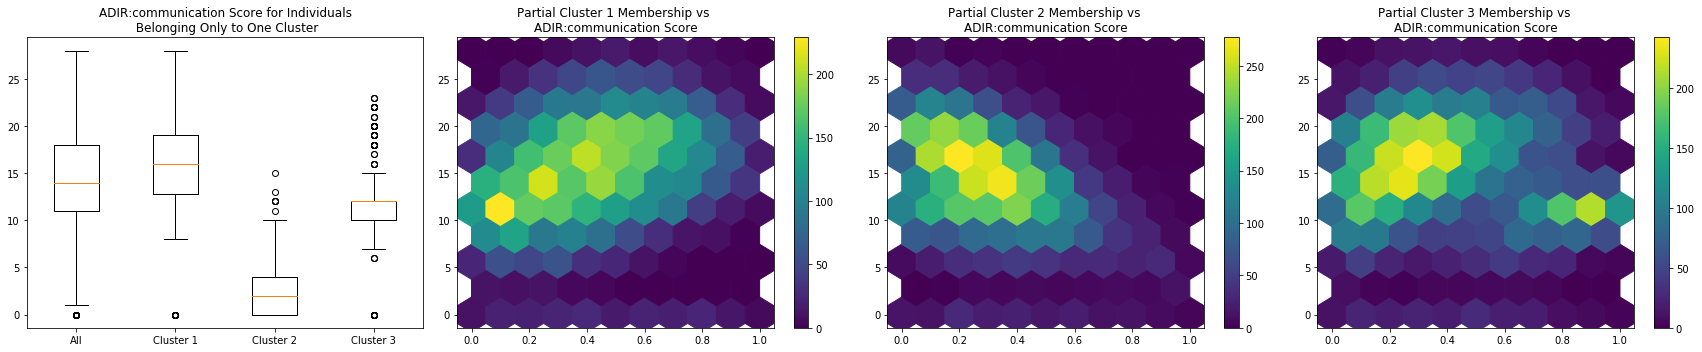

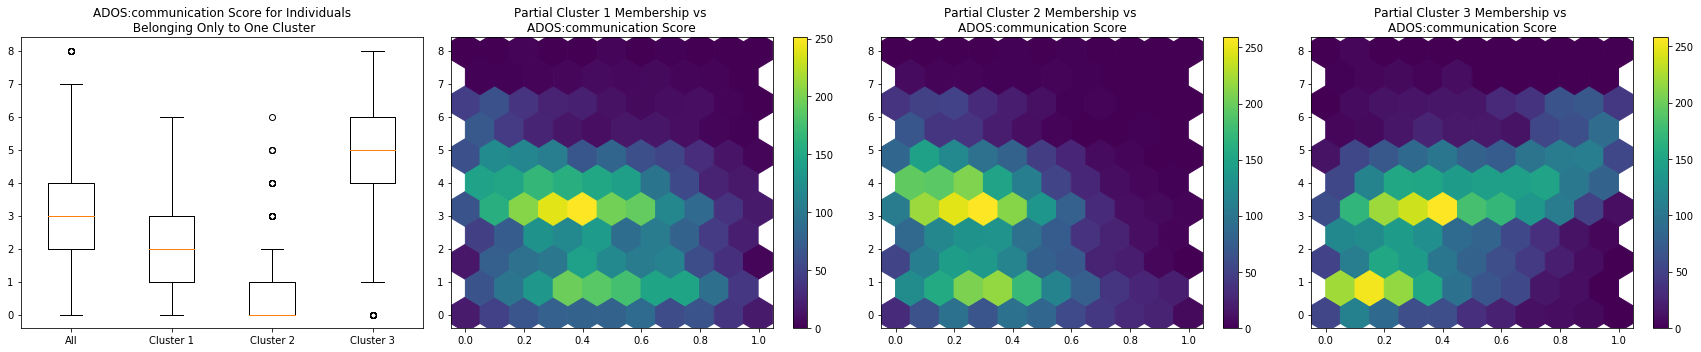

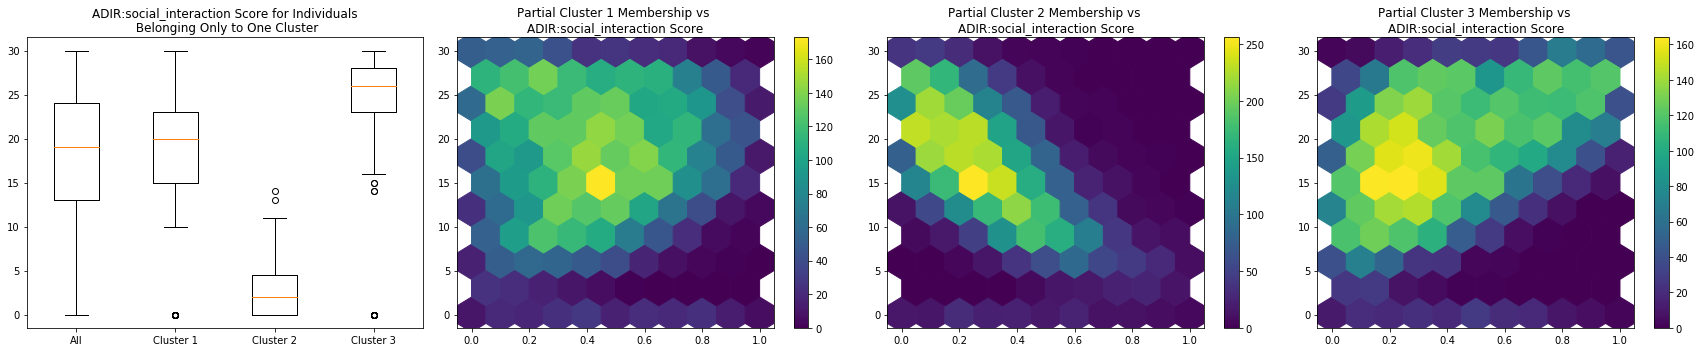

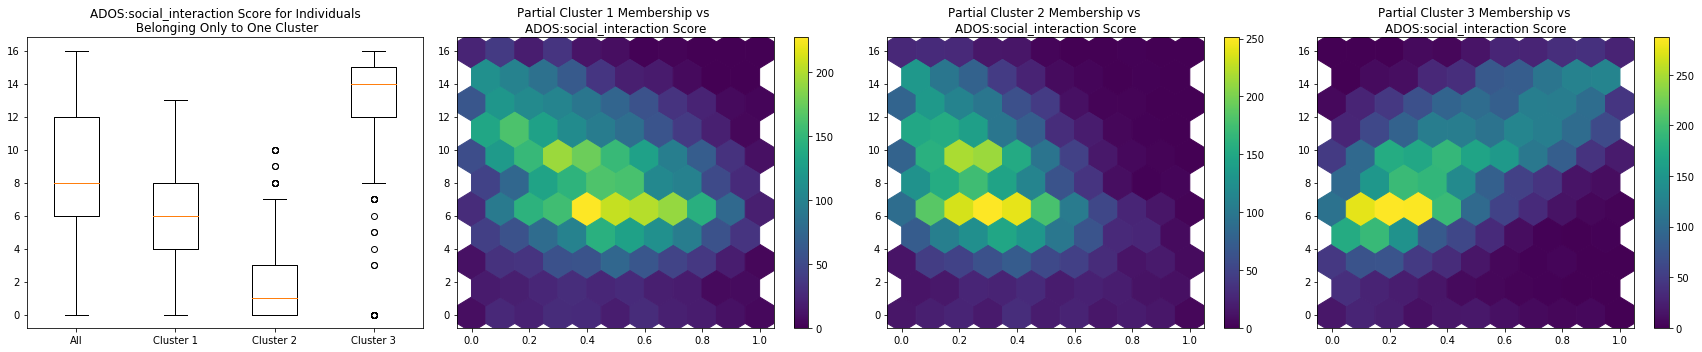

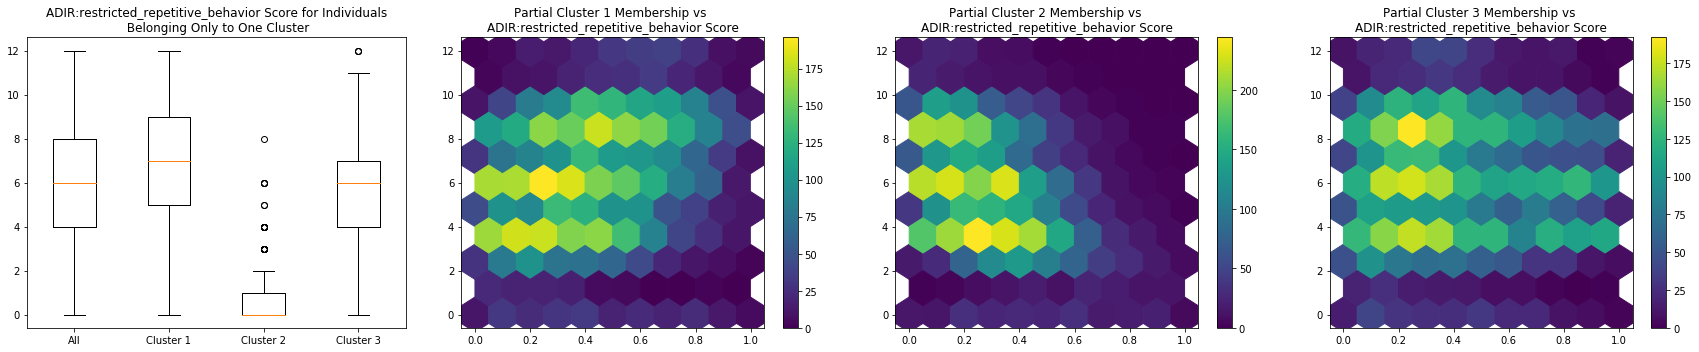

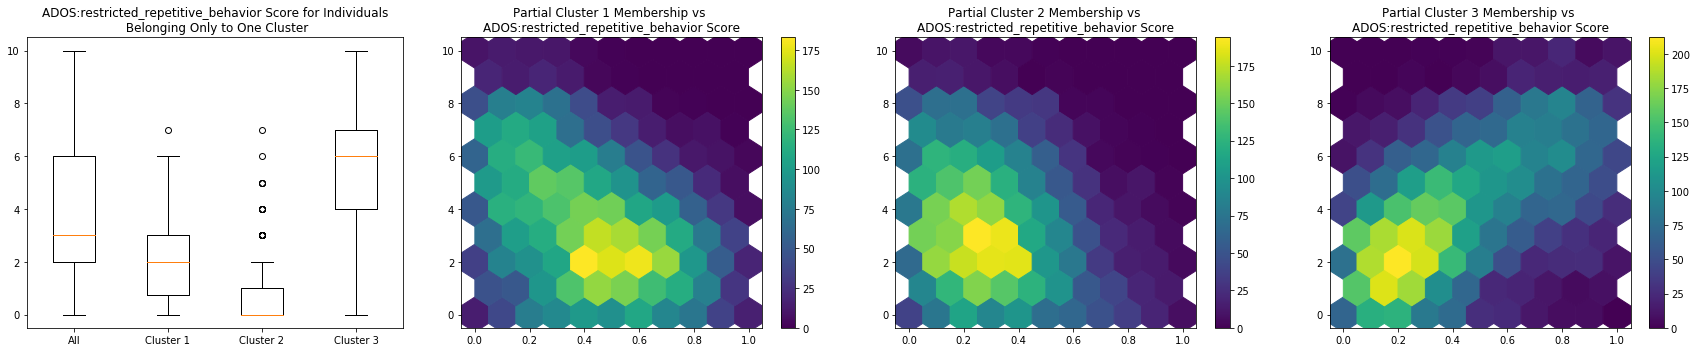

In [628]:
for key in ['ADIR:communication', 'ADOS:communication', 
            'ADIR:social_interaction', 'ADOS:social_interaction', 
            'ADIR:restricted_repetitive_behavior', 'ADOS:restricted_repetitive_behavior']:
    #print(key)
    scores = np.asarray([int(get_label(i, key)) for i in range(m)])
    plt.figure(figsize=(8*k, 5))
    boxplot_data = [scores]
    for i in range(k):
        plt.subplot(1, k+1, i+2)
        indexes = np.logical_and(X[i, :] > 0, X[i, :] < 1)
        cay = plt.hexbin(X[i, indexes], scores[indexes], gridsize=10)
        plt.colorbar(cay)
        plt.title('Partial Cluster %d Membership vs \n%s Score' % (i+1, key))
        
        boxplot_data.append(scores[X[i, :] > .9])
    
    plt.subplot(1, k+1, 1)
    #print([len(x) for x in boxplot_data])
    plt.boxplot(boxplot_data, labels=['All', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
    plt.title('%s Score for Individuals\n Belonging Only to One Cluster' % key)
    plt.tight_layout()
    plt.show()

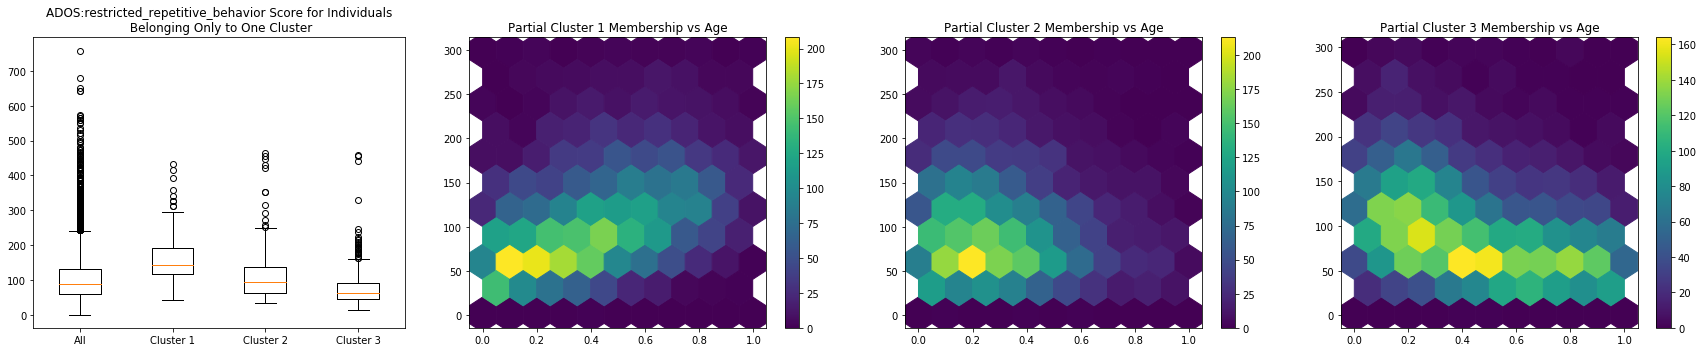

In [652]:
plt.figure(figsize=(8*k, 5))
boxplot_data = [[x for x in age if x is not None]]
for i in range(k):
    plt.subplot(1, k+1, i+2)
    indexes = [j for j in range(m) if age[j] is not None and age[j] < 300 and X[i, j] > 0 and X[i, j] < 1]
    ages = [age[j] for j in indexes]
    cay = plt.hexbin(X[i, indexes], ages, gridsize=10)
    plt.colorbar(cay)
    plt.title('Partial Cluster %d Membership vs Age' % (i+1))
    

    boxplot_data.append([age[j] for j in range(m) if X[i, j] > .9 and age[j] is not None])
    
plt.subplot(1, k+1, 1)
#print([len(x) for x in boxplot_data])
plt.boxplot(boxplot_data, labels=['All', 'Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.title('%s Score for Individuals\n Belonging Only to One Cluster' % key)
plt.tight_layout()
plt.show()

In [533]:
print(Counter([tuple(np.round(4*X[:, i])/4) for i in range(m)]))    

Counter({(0.0, 0.0, 1.0): 997, (0.5, 0.25, 0.25): 741, (0.75, 0.0, 0.25): 714, (0.25, 0.0, 0.75): 710, (0.5, 0.0, 0.5): 671, (0.5, 0.5, 0.0): 580, (0.0, 0.25, 0.75): 550, (0.75, 0.25, 0.0): 537, (0.25, 0.25, 0.5): 530, (0.25, 0.5, 0.25): 520, (0.0, 0.5, 0.5): 394, (1.0, 0.0, 0.0): 312, (0.0, 1.0, 0.0): 286, (0.25, 0.75, 0.0): 238, (0.0, 0.75, 0.25): 140, (0.5, 0.25, 0.5): 127, (0.25, 0.25, 0.25): 120, (0.5, 0.25, 0.0): 104, (0.5, 0.0, 0.25): 104, (0.75, 0.25, 0.25): 98, (0.5, 0.5, 0.25): 95, (0.25, 0.5, 0.5): 75, (0.25, 0.0, 0.5): 72, (0.75, 0.0, 0.0): 65, (0.0, 0.25, 0.5): 59, (0.25, 0.25, 0.75): 58, (0.0, 0.0, 0.75): 54, (0.25, 0.5, 0.0): 49, (0.0, 0.5, 0.25): 46, (0.25, 0.75, 0.25): 39, (0.0, 0.75, 0.0): 15})


In [513]:
with open("../data/AutismPhenotype.json") as schema_file:    
    pheno_schema = json.load(schema_file)
    descriptions = [pheno_schema["definitions"]["ADIR"]["properties"][x[5:]]["description"] if x.startswith("ADIR") else pheno_schema["definitions"]["ADOS"]["properties"][x[5:]]["description"] for x in header[1:]]

diff_between_1_3 = []
for j in range(n):
    if (Y[0, j] > 0 and Y[2, j] < 0) or (Y[0, j] < 0 and Y[2, j] > 0):
        diff_between_1_3.append((Y[0, j], Y[2, j], descriptions[j]))

print('\n'.join(['%f\t%f\t%s' % x for x in sorted(diff_between_1_3, key=lambda x: abs(x[0]-x[1]), reverse=True)]))
    
for i in range(k):
    print(i)
    print('\n'.join(['%f\t%s|%s' % (s, h, d) for h, d, s in sorted(zip(header[1:], descriptions, Y[i, :]), key=lambda x: x[2], reverse=True) if s > 0]))
    
    

-5.181754	1.500122	Overall level of language
-2.794597	3.343431	Functional play with objects
-2.430717	3.083852	Overall level of non-echoed spoken language
-0.169587	5.198368	Amount of social overtures/maitenance of attention
-3.784041	1.223269	Current use of other's body to communicate
3.132563	-1.836836	Ever inappropriate questions or statements
-1.451492	3.448684	Current nodding
-0.304070	4.339448	Showing
3.765490	-0.852513	Ever circumscribed interests
-2.481637	1.970955	Immediate echolalia
3.421799	-0.978773	Current circumscribed interests
2.632629	-1.728805	Current inappropriate questions or statements
-2.056954	2.234301	Current pronominal reversal
-3.778980	0.436435	Response to joint attention
-1.021722	3.127689	Current comprehension of simple language
-0.803985	3.322758	At 4-5 nodding
-0.454940	3.432299	Ever current communicative speech
-1.401141	2.192324	Ever use of other's body to communicate
-1.418012	2.175017	Responsive social smile
-0.370246	3.216351	Pointing
-1.124354	2.45